#### Imports 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers


from matplotlib import pyplot as plt
import seaborn as sns

sns.set()


# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

#### Load Dataset

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [3]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
511,-117.0,32.7,15.0,825.0,130.0,334.0,131.0,4.0,169500.0
2239,-117.4,33.8,8.0,1954.0,330.0,973.0,321.0,4.5,249100.0
11553,-121.3,38.0,26.0,378.0,75.0,164.0,65.0,3.4,82800.0
1907,-117.3,34.1,42.0,1811.0,345.0,856.0,352.0,3.0,97000.0
16218,-122.5,37.8,52.0,2556.0,595.0,1202.0,568.0,3.9,348500.0


#### Normalize Values
Z-Score: $z = \frac{X-\mu}{\sigma}$

In [11]:
# Normalize train set
mean_train = train_df.mean()
std_train = train_df.std()
norm_train_df = (train_df-mean_train) / std_train

norm_train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
511,1.3,-1.4,-1.1,-0.8,-1.0,-1.0,-1.0,0.1,-0.3
2239,1.1,-0.9,-1.6,-0.3,-0.5,-0.4,-0.5,0.3,0.4
11553,-0.9,1.1,-0.2,-1.0,-1.1,-1.1,-1.1,-0.2,-1.1
1907,1.1,-0.7,1.1,-0.4,-0.5,-0.5,-0.4,-0.5,-1.0
16218,-1.5,1.0,1.9,-0.0,0.1,-0.2,0.2,0.0,1.2


In [12]:
# Normalize test set
mean_test = test_df.mean()
std_test = test_df.std()
norm_test_df = (test_df-mean_test) / std_test

norm_test_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1


#### Creating Binary Classes

In [19]:
threshold = train_df.median_house_value.quantile(q = .75)
norm_train_df["median_house_value_is_high"] = (train_df.median_house_value > threshold).astype(int)
norm_test_df["median_house_value_is_high"] = (test_df.median_house_value > threshold).astype(int)

norm_train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
511,1.3,-1.4,-1.1,-0.8,-1.0,-1.0,-1.0,0.1,-0.3,0
2239,1.1,-0.9,-1.6,-0.3,-0.5,-0.4,-0.5,0.3,0.4,0
11553,-0.9,1.1,-0.2,-1.0,-1.1,-1.1,-1.1,-0.2,-1.1,0
1907,1.1,-0.7,1.1,-0.4,-0.5,-0.5,-0.4,-0.5,-1.0,0
16218,-1.5,1.0,1.9,-0.0,0.1,-0.2,0.2,0.0,1.2,1


#### Represent Features in Feature Column 

In [20]:
feature_columns = list()

med_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(med_income)

tot_rooms = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tot_rooms)

##
# Convert the feature columns into feature layer
# that will be fed into the model later.
##
feature_layer = layers.DenseFeatures(feature_columns)

feature_layer(dict(norm_train_df))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 0.08150374, -0.83427   ],
       [ 0.31649494, -0.3163675 ],
       [-0.24781935, -1.0393208 ],
       ...,
       [ 0.33462763, -0.8429858 ],
       [-0.18461698, -0.67784417],
       [-0.95436513, -0.04250764]], dtype=float32)>

#### Define Model Functions 

In [23]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    """Create and compile a simple classification model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the feature layer (the list of features and how they are represented)
    # to the model.
    model.add(feature_layer)

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        


def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.  Here, we're passing
    # every column in the dataset. Note that the feature_layer will filter
    # away most of those columns, leaving only the desired columns and their
    # representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the model functions.")   

Defined the model functions.


#### Define Plotting Function 

In [28]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    plt.figure(figsize=(12,7))
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


#### First Invoke

In [32]:
def evaluate_model(df, label_name = None, learning_rate = 0.001, epochs = 10, batch_size = 100, metrics = None, list_of_metrics_to_plot = []):
    # Establish the model's topography.
    my_model = create_model(learning_rate, feature_layer, metrics)

    # Train the model on the training set.
    epochs, hist = train_model(my_model, df, epochs, label_name, batch_size)

    plot_curve(epochs, hist, list_of_metrics_to_plot)
    
    return my_model

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 0s 27us/sample - loss: 0.6706 - accuracy: 0.4167
Epoch 2/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.5997 - accuracy: 0.5377
Epoch 3/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.5410 - accuracy: 0.6339
Epoch 4/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4953 - accuracy: 0.7038
Epoch 5/20
17000/17000 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.74 - 0s 11us/sample - loss: 0.4603 - accuracy: 0.7484
Epoch 6/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.4357 - accuracy: 0.7751
Epoch 7/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4193 - accuracy: 0.7928
Epoch 8/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.4092 - accuracy: 0.8011
Epoch 9/20
17000/17000 [==============================] - 0s 12us/sample - loss

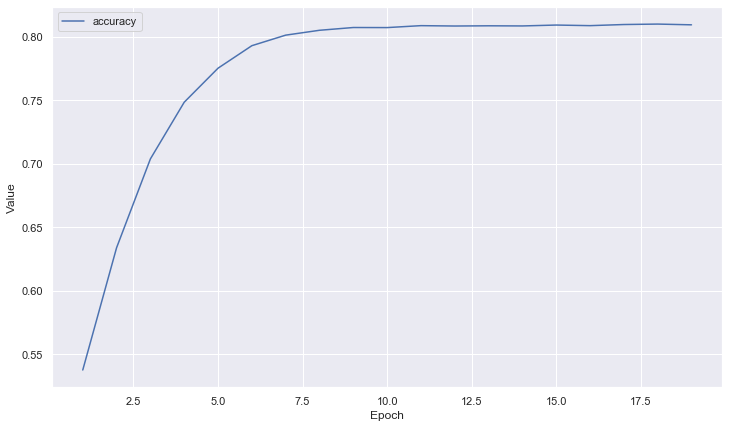

In [33]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
metrics = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

my_model = evaluate_model(norm_train_df, label_name, learning_rate, epochs, batch_size, metrics, ["accuracy"])

#### Testing Our Model

In [34]:
features = {name:np.array(value) for name, value in norm_test_df.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

3000/3000 [==============================] - 0s 38us/sample - loss: 0.4068 - accuracy: 0.8013


[0.4068253149588903, 0.8013333]

> A perfect model would make 100% accurate predictions, but our model made 80.1%. Seems good.

#### Add **precision** and **recall** to metrics

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 58us/sample - loss: 0.6032 - accuracy: 0.5111 - precision: 0.3213 - recall: 0.8604
Epoch 2/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.5419 - accuracy: 0.6029 - precision: 0.3694 - recall: 0.8335
Epoch 3/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4950 - accuracy: 0.6647 - precision: 0.4122 - recall: 0.8032
Epoch 4/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4607 - accuracy: 0.7091 - precision: 0.4519 - recall: 0.7723
Epoch 5/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4359 - accuracy: 0.7405 - precision: 0.4874 - recall: 0.7450
Epoch 6/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4184 - accuracy: 0.7633 - precision: 0.5191 - recall: 0.7123
Epoch 7/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4075 - accuracy: 0.7814 - prec

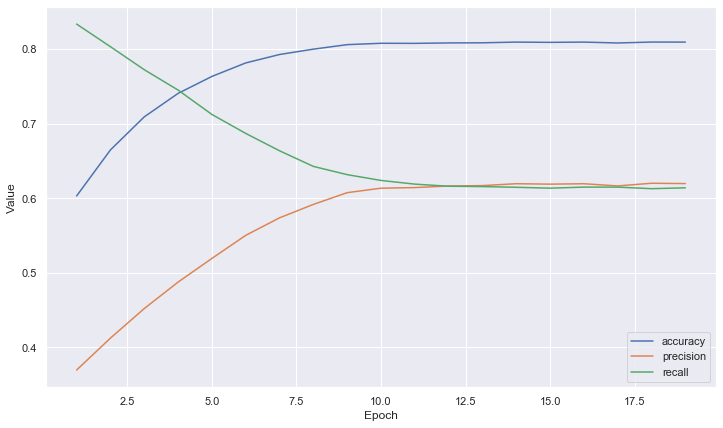

In [37]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
metrics = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(name="precision",
                                     thresholds=classification_threshold),
           tf.keras.metrics.Recall(name="recall",
                                  thresholds=classification_threshold),
          ]

my_model = evaluate_model(norm_train_df, label_name, learning_rate, epochs, batch_size, metrics, ["accuracy", "precision", "recall"])

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 57us/sample - loss: 0.5803 - accuracy: 0.7419 - precision: 0.4888 - recall: 0.7196
Epoch 2/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.5332 - accuracy: 0.7618 - precision: 0.5175 - recall: 0.6842
Epoch 3/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.4937 - accuracy: 0.7800 - precision: 0.5508 - recall: 0.6478
Epoch 4/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4614 - accuracy: 0.7965 - precision: 0.5896 - recall: 0.6105
Epoch 5/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.4368 - accuracy: 0.8131 - precision: 0.6385 - recall: 0.5806
Epoch 6/20
17000/17000 [==============================] - 0s 11us/sample - loss: 0.4194 - accuracy: 0.8222 - precision: 0.6788 - recall: 0.5474
Epoch 7/20
17000/17000 [==============================] - 0s 10us/sample - loss: 0.4081 - accuracy: 0.8286 - prec

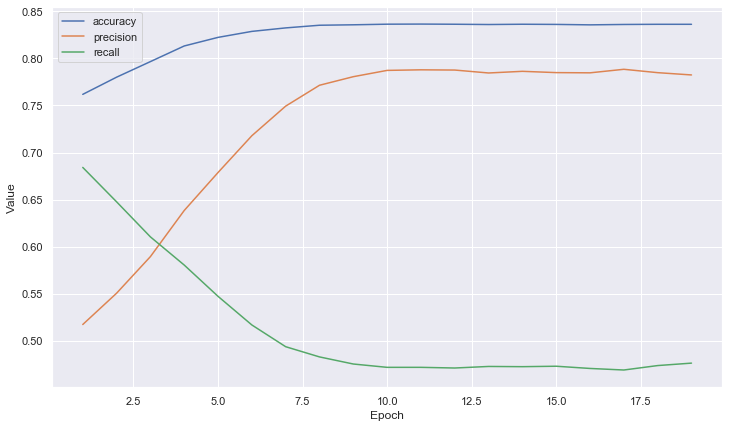

In [42]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = .52

# Establish the metrics the model will measure.
metrics = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(name="precision",
                                     thresholds=classification_threshold),
           tf.keras.metrics.Recall(name="recall",
                                  thresholds=classification_threshold),
          ]

my_model = evaluate_model(norm_train_df, label_name, learning_rate, epochs, batch_size, metrics, ["accuracy", "precision", "recall"])

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 40us/sample - loss: 1.1174 - auc: 0.2476
Epoch 2/20
17000/17000 [==============================] - 0s 13us/sample - loss: 1.0099 - auc: 0.2519
Epoch 3/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.9118 - auc: 0.2577
Epoch 4/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.8241 - auc: 0.2665
Epoch 5/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.7473 - auc: 0.2790
Epoch 6/20
17000/17000 [==============================] - 0s 12us/sample - loss: 0.6826 - auc: 0.3012
Epoch 7/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.6274 - auc: 0.3505
Epoch 8/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.5812 - auc: 0.4753
Epoch 9/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.5414 - auc: 0.6936
Epoch 10/20
17000/17000 [==============================] - 

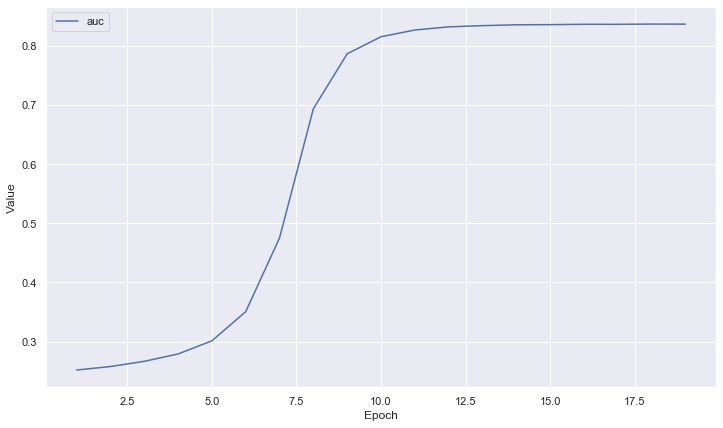

In [47]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = .52

# Establish the metrics the model will measure.
metrics = [
           tf.keras.metrics.AUC(name="auc",
                               num_thresholds=100)
          ]

my_model = evaluate_model(norm_train_df, label_name, learning_rate, epochs, batch_size, metrics, ["auc"])